# Transformer
## Transformer Framework

<img src="./transformer.png" width="800">

* 基于编码器解码器架构来处理序列对
* 跟使用注意力的seq2seq不同, Transformer是**纯**基于注意力

## Multi-Head Attention

<img src="./multihead.PNG" width="500">

* 对于同一key, value, query, 希望抽取不同的信息
    * 例如短距离关系和长距离关系
* 多头注意力使用h个独立的注意力池化
    * 合并各个头(head)输出得到最终输出
    
    
* Q, K, V:
    * query $\mathbf{q} \in \mathbb{R}^{d_q}$
    * key $\mathbf{k} \in \mathbb{R}^{d_k}$
    * value $\mathbf{v} \in \mathbb{R}^{d_v}$
* 头$i$的可学习参数$\mathbf{W}_i^{(q)} \in \mathbb{R}^{p_q \times d_q}, \mathbf{W}_i^{(k)} \in \mathbb{R}^{p_k \times d_k}, \mathbf{W}_i^{(v)} \in \mathbb{R}^{p_v \times d_v}$
  
  
* 头$i$的输出$\mathbf{h}_i = f(\mathbf{W}_i^{(q)}\mathbf{q}, \mathbf{W}_i^{(k)}\mathbf{k}, \mathbf{W}_i^{(v)}\mathbf{v}) \in \mathbb{R}^{p_v}$


* 输出的可学习参数$\mathbf{W}_o \in \mathbb{R}^{p_o \times hp_v}$


* 多头注意力的输出 (把所有$h$ concat)
$$
\mathbb{W}_o 
\begin{bmatrix}
\mathbf{h}_1\\
...\\
\mathbf{h}_h
\end{bmatrix}
\in \mathbb{R}^{p_o}
$$

## 有掩码的多头注意力

* 解码器对序列中一个元素输出时, 不应该考虑该元素之后的元素 (autoregressive)
* 可以通过掩码来实现
    * 也就是计算$\mathbf{x}_i$输出时, 假装当前序列长度为$i$ 

## 基于位置的前馈网络 (FFN)
* 将输入形状由$(b,n,d)$变换成$(bn,d)$ 因为$n$会变, 和模型无关


* 作用两个全连接层


* 输出形状由$(bn,d)$变换成$(b,n,d)$


* 等价于两层核窗口为1的一维卷积层

## 层归一化 (LayerNorm)

* 批量归一化(BatchNorm)对每个**特征/通道 (d)**里元素进行归一化
    * 不适合序列长度会变的nlp应用 (n会变, 会导致结果不稳定)
 <img src="./batch_layer_norm.PNG" width="500">
 
 
 
* 层归一化对每个**样本 (b)**里的元素进行归一化 (虽然长度还是会变, 至少是单样本)

## 信息传递 (Encoder-Decoder Attention)

* 编码器中的输出$\mathbf{y}_1, ..., \mathbf{y}_n$


* 将其作为解码器中第$i$个Transformer块中多头注意力的key和value
    * 它的query来自目标序列
    
    
* 意味着编码器和解码器中块的个数和输出维度都是一样的

## 预测
* 预测$t+1$个输出时
* 解码器中输入前$t$个预测值
    * **在自注意力中，前$t$个预测值作为key和value, 第$t$个预测值还作为query**

## 总结
* Transformer时一个纯使用注意力的编码器-解码器
* 编码器和解码器都有n个transformer blocks
* 每个block里使用multi-head (self) attention, feed-forward neural network, and LayerNorm

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

选择缩放点积注意力作为每一个注意力头

In [48]:
from utils import DotProductAttention, PositionalEncoding, train_seq2seq

In [3]:
def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    
    X = X.permute(0, 2, 1, 3)
    
    # combine the batch_size and num_heads dimensions
    return X.reshape(-1, X.shape[2], X.shape[3]) 

def transpose_output(X, num_heads):
    # Reverse of transpose_qkv
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens,
                                                 repeats=self.num_heads,
                                                 dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
            

In [5]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3,2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## Transformer

In [6]:
import pandas as pd

In [7]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [8]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape # change the output dimension to 8

torch.Size([2, 3, 8])

对不用维度的层归一化和批量归一化的效果

In [9]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm', ln(X), '\nbatch norm:', bn(X))

layer norm tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


使用残差连接和层归一化

In [10]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [11]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size,
                                            value_size, num_hiddens,
                                            num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # FFN output dimension = num_hiddens
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, 
                                   num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

Transformer编码器中的任何层都不会改变其输入的形状

In [13]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

Transformer Encoder

In [17]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens, 
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
            
    def forward(self, X, valid_lens, *args):
        # positional encoding output in range [-1, 1], so need to scale up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X
        

创建一个两层的Transformer编码器

In [18]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape
# batch_size, sequence_length, num_hiddens

torch.Size([2, 100, 24])

In [20]:
class DecoderBlock(nn.Module):
    """The i-th block in the decoder"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size,
                                             value_size, num_hiddens,
                                             num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size,
                                             value_size, num_hiddens,
                                             num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None: # Training
            key_values = X
        else: # Prediction
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                                batch_size, 1)
        else:
            dec_valid_lens = None
        
        # key_values will be different when training and prediction
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
        

Feature dimensions for BOTH Encoder and Decoder are the same: num_hiddens

In [21]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Transformer Decoder

In [25]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights
        

loss 0.026, 11763.7 tokens/sec on cuda:0


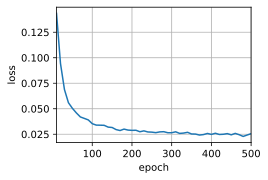

In [31]:
# key hyperparameters: num_hiddens, num_heads
num_hiddens, num_layers, dropout, batch_size, num_steps = 64, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 500, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 64, 128, 8
key_size, query_size, value_size = 64, 64, 64
norm_shape = [64]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [32]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est demande .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


Visualize the Transformer attention weights

In [33]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 8, 10, 10])

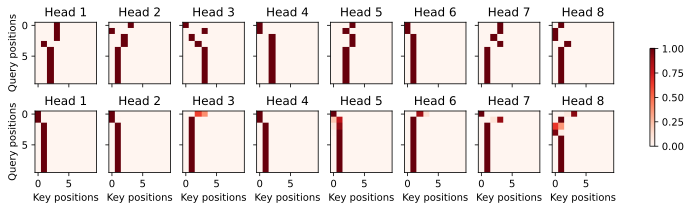

In [43]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 9)], figsize=(13, 3))

为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作

In [40]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 8, 6, 10]), torch.Size([2, 8, 6, 10]))

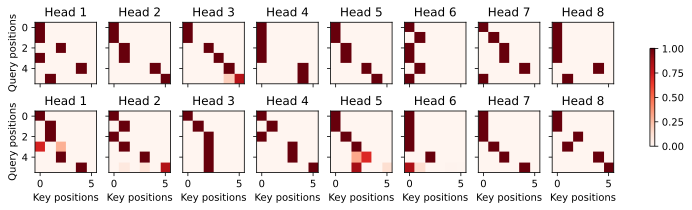

In [44]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 9)], figsize=(13, 3))

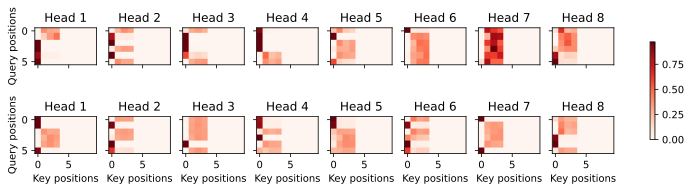

In [47]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 9)], figsize=(13, 3))
